In [1]:
import os
import numpy as np
J_ROOT = os.readlink('/proc/%s/cwd' % os.environ['JPY_PARENT_PID'])
npzpath = os.path.join(J_ROOT, 'data/pecot_dice', "annotated_datasets/23-09-15_Annotation/23-11-07_32x32_cNp_erdi_nSeg/npz/data.npz")

In [2]:
data = np.load(npzpath)

In [3]:
data.files

['channels',
 'y_all',
 'central_y',
 'batch',
 'pixels_x',
 'pixels_y',
 'win_x',
 'win_y']

In [4]:
data['y_all'].shape

(144, 1076, 1076, 3)

In [5]:
from training_cmdline import *

2023-11-15 22:12:11.425015: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 22:12:16.821752: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 22:12:17.803030: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11256 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0000:8a:00.0, compute capability: 3.7


In [6]:
train_dict, (X_test, Y_test) = get_data_sample(npzpath)

In [7]:
train_dict.keys()

dict_keys(['channels', 'batch', 'pixels_x', 'pixels_y', 'labels', 'win_x', 'win_y'])

In [8]:
train_dict['labels'].shape

(144, 1076, 1076, 3)

In [10]:
print(f"X-test: {X_test.shape}\nY-test: {Y_test.shape}")

X-test: (237538, 128, 128, 1)
Y-test: (237538, 128, 128, 3)


In [11]:
def plotXYsingle(X, Y):
    fig = plt.figure(figsize = (20, 5))
    ax1 = fig.add_subplot(141)
    ax2 = fig.add_subplot(142)
    ax3 = fig.add_subplot(143)
    ax4 = fig.add_subplot(144)
    ax1.imshow(X[:, :, :])
    ax2.imshow(Y[:, :, 0])
    ax3.imshow(Y[:, :, 1])
    ax4.imshow(Y[:, :, 2])

def plotXY(X, Y, jindex = 4):
    fig = plt.figure(figsize = (20, 5))
    ax1 = fig.add_subplot(141)
    ax2 = fig.add_subplot(142)
    ax3 = fig.add_subplot(143)
    ax4 = fig.add_subplot(144)
    ax1.imshow(X[jindex, :, :, :])
    ax2.imshow(Y[jindex, :, :, 0])
    ax3.imshow(Y[jindex, :, :, 1])
    ax4.imshow(Y[jindex, :, :, 2])

In [12]:
train_dict['labels'].shape

(144, 1076, 1076, 3)

In [13]:
def random_sample_generator2(img, img_ind, x_coords, y_coords, y_init, 
                            batch_size, n_channels, n_classes, win_x, 
                            win_y, augmentation = True):

    cpt = 0

    n_images = len(img_ind)
    arr = np.arange(n_images)
    np.random.shuffle(arr)

    while(True):

        # buffers for a batch of data - CHANGED ARS 06/07/2023
        batch_x = np.zeros(
            (batch_size, 2*win_x, 2*win_y, n_channels), 
            dtype='float32')
        batch_y = np.zeros(
            (batch_size, 2*win_x, 2*win_y, n_classes), 
            dtype='float32')
        
        # get one image at a time
        for k in range(batch_size):

            # get random image
            img_index = arr[cpt%len(img_ind)]

            # open images
            patch_x = img[img_ind[img_index], 
                (x_coords[img_index]-win_x):(x_coords[img_index]+win_x),
                (y_coords[img_index]-win_y):(y_coords[img_index]+win_y),
            :]
            patch_x = np.asarray(patch_x)
            
            current_class = y_init[img_ind[img_index],
                (x_coords[img_index]-win_x):(x_coords[img_index]+win_x),
                (y_coords[img_index]-win_y):(y_coords[img_index]+win_y),
            :]
            current_class = np.asarray(current_class)
            current_class = current_class[np.newaxis, :, :, :]

            #if augmentation:
            if augmentation:
                augmentationMap = GenerateRandomImgaugAugmentation(
                    pEnableRandomNoise=True
                )
                patch_x, current_class = augmentationMap(
                    image = patch_x, 
                    segmentation_maps = current_class
                )

            # save image to buffer
            batch_x[k, :, :, :] = patch_x.astype('float32')
            batch_y[k, :, :, :] = current_class.astype('float32')
            cpt += 1

        assert len(batch_x[~np.isfinite(batch_x)]) == 0
        assert len(batch_y[~np.isfinite(batch_y)]) == 0
        assert len(batch_y[(batch_y != 0) & (batch_y != 1)]) == 0
        
        # return the buffer
        yield (batch_x, batch_y)

In [14]:
train_gen = random_sample_generator2(
        train_dict["channels"], train_dict["batch"], 
        train_dict["pixels_x"], train_dict["pixels_y"], 
        train_dict["labels"], 16, 1, 3, 
        train_dict["win_x"], train_dict["win_y"], True)

In [15]:
X, Y = 0, 0
for x, y in train_gen:
    X, Y = x, y
    break

In [16]:
print(f"X: {X.shape}\nY: {Y.shape}")

X: (16, 128, 128, 1)
Y: (16, 128, 128, 3)


In [17]:
import matplotlib.pyplot as plt

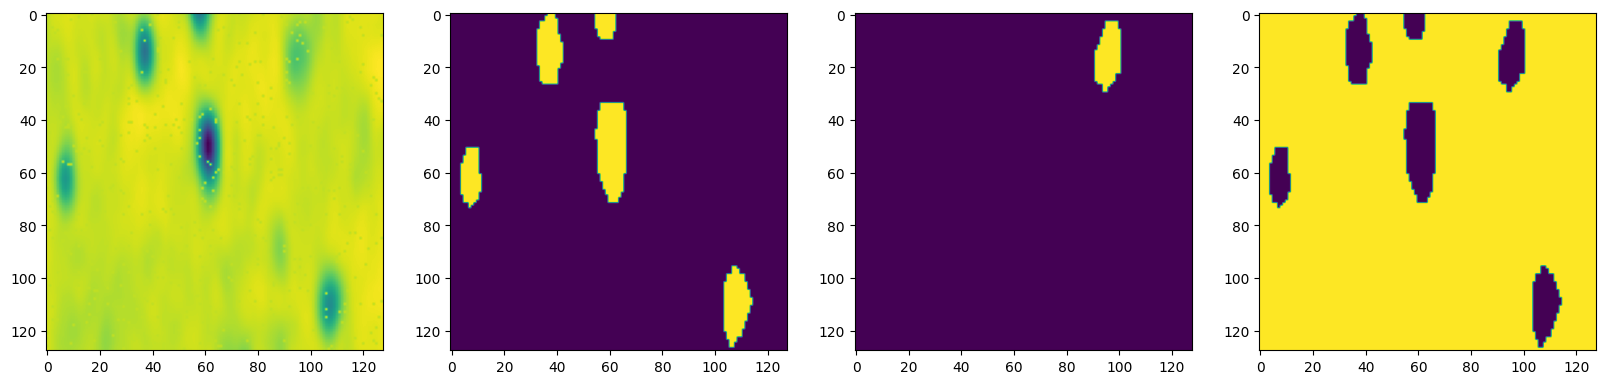

In [18]:
plotXY(X, Y, 4)

In [57]:
def gen_Yh():
    Yh = tf.random.uniform(shape=(16, 128, 128, 3))
    Yh = np.array(Yh)
    Yh[:,:,:,:] /= Yh[:,:,:,:].max()
    Yh[:,:,:,:][Yh[:,:,:,:] >= 0.5] = 1
    Yh[:,:,:,:][Yh[:,:,:,:] < 0.5] = 0
    Yh = tf.constant(Yh)
    return Yh

In [53]:
def diceloss2(y_true, y_pred, weights = [1, 1, 1]):

    def dice_coef(y_true, y_pred, smooth=0):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true * y_pred)
        dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        return dice
        
    # if y_true.shape[-3:] != (128, 128, 3):
    #     raise ValueError(f"y_true has shape {y_true.shape}")

    # for fidx in np.arange(y_true.shape[-1]):

    i1 = dice_coef(y_true[:,:,:,0], y_pred[:,:,:,0])
    i2 = dice_coef(y_true[:,:,:,1], y_pred[:,:,:,1])
    i3 = dice_coef(y_true[:,:,:,2], y_pred[:,:,:,2])
    dice_coefs = [weights[0] * i1, weights[1] * i2, weights[2] * i3]
        
    return -K.log(K.sum(dice_coefs) / K.cast(K.shape(dice_coefs)[0], tf.float32))

In [58]:
n = 1000
losslist = []
for i in range(n):
    Yh = gen_Yh()
    losslist.append(diceloss2(Y, Yh))

(array([  1.,   3.,  21.,  88., 181., 265., 248., 146.,  41.,   6.]),
 array([1.34701443, 1.3482573 , 1.34950018, 1.35074317, 1.35198605,
        1.35322893, 1.3544718 , 1.35571468, 1.35695767, 1.35820055,
        1.35944343]),
 <BarContainer object of 10 artists>)

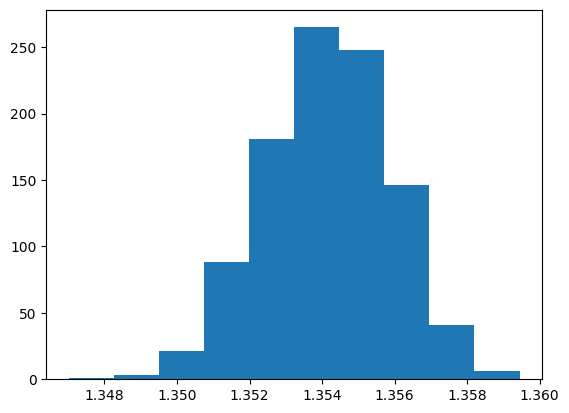

In [59]:
plt.hist(losslist)